# Imports

In [519]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.lines import Line2D
import geopandas as gpd
import json
from matplotlib.patches import Patch
from shapely.geometry import Point

In [520]:
# figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set_theme(style="whitegrid")
sns.set_palette(palette="Paired")

# set seed
np.random.seed(42)

# Load train and test data

In [521]:
X_train = pd.read_csv("../../data/raw/train_values.csv")
y_train = pd.read_csv("../../data/raw/train_labels.csv")
#districts = pd.read_csv("../../data/raw/districts.csv", skiprows=[0], sep=";", decimal=",")

In [522]:
#X_train = X_train.iloc[:100000] # max 260601
#y_train = y_train.iloc[:100000] # max 260601

In [523]:
#sample_size = y_train.shape[0]

# Load survey data
Survey data of the Household Registration for Housing Reconstruction Survey 2016-2017 was made publicly available in the [Household Registration for Housing Reconstruction Survey 2016-2017 Report](https://microdata.cbs.gov.np/index.php/catalog/69/data-dictionary/F1?file_name=Main_Table) by the "Central Bureau of Statistics - Nation Planning Commission Secretariat, Government of Nepal". From their online Microdata Catalogue you can download the basic vairiables statistics of as a csv file. This includes the district names, their respective district codes as well as statistics about the numbers of cases per district, so that a Response Rate for each district in regard to the actual number of survey participants can be calculated.

In [524]:
# Path to the downloaded survey data file
survey_data = pd.read_csv("../../data/raw/variables-06-01-23-062049.csv", header=0)

In [525]:
# Get survey statistics about the number of cases per district
survey_stats = json.loads(survey_data.at[0, 'var_catgry'])
df_survey_stats = pd.DataFrame(survey_stats).explode('stats')
# Extract the value of the 'value' key in the stats and create a DataFrame
df_stats_values = pd.DataFrame(df_survey_stats['stats'].tolist()).rename(columns={'value': 'cases_absolute'})
df_stats_values['cases_absolute']  = df_stats_values['cases_absolute'].astype(int)
# Combine the original DataFrame with the extracted stats values DataFrame
df_survey_stats = pd.concat([df_survey_stats, df_stats_values], axis=1)
# Rename columns
df_survey_stats.rename(columns={"labl": "district", "value": "dcode"}, inplace=True)
# Change data type
df_survey_stats['dcode'] = df_survey_stats['dcode'].astype(int)
# Drop unnecessary columns
df_survey_stats.drop(['stats', 'is_missing', 'type', 'wgtd'], axis=1, inplace=True)

In [526]:
# Add more statistics
df_survey_stats['cases_total'] = df_survey_stats['cases_absolute'].sum()
df_survey_stats['cases_relative'] = df_survey_stats['cases_absolute'] / df_survey_stats['cases_total'] * 100
df_survey_stats.sort_values(by=['cases_absolute'], ascending=True, inplace=True)

In [527]:
df_survey_stats

,dcode,district,cases_absolute,cases_total,cases_relative
29,48,Nawalparasi,976,996588,0.097934
24,43,Myagdi,1350,996588,0.135462
30,51,Arghakhanchi,1625,996588,0.163056
26,45,Baglung,3815,996588,0.382806
0,7,Dhankuta,4491,996588,0.450638
1,9,Sankhuwasabha,4966,996588,0.498300
27,46,Gulmi,6894,996588,0.691760
2,10,Bhojpur,9242,996588,0.927364
28,47,Palpa,10398,996588,1.043360
23,40,Kaski,10739,996588,1.077577


In [528]:
df_survey_stats.to_csv("../../data/processed/survey_stats.csv", index=False)

# Map geographical data to districts (latitude, longitude -> district)
Strategy: Retrieve the shapefile or GeoJSON data for the districts of Nepal and perform geocoding based on the shapefile's boundaries using the geopandas library -> most accurate method.
* See [administrative boundary datasets for Nepal](https://data.humdata.org/dataset/administrative-boundaries-of-nepal), provided by the Humanitarian Data Exchange (HDX)
* See [district boundary dataset for Nepal](https://codefornepal.carto.com/tables/shape_files_of_districts_in_nepal/public), created by the [Code For Nepal](https://codefornepal.org/) organization

For consistency reasons we will use the district boundaries provided by the Code For Nepal organization, since they are more up-to-date and contain the same district names as the survey data. The HDX dataset contains district names that are not consistent with the survey data. For example, the district name "Kavrepalanchok" is written as "Kavre" in the HDX dataset. Also, the other team members also use this dataset.

Also, the epicenter of the earthquake is located in the Gurkha district. The exact coordinates of the epicenter are: 28.230° N, 84.731° E ([source](https://en.wikipedia.org/wiki/April_2015_Nepal_earthquake)).

In [529]:
# Path to the downloaded district boundaries shape files
file_path = "../../data/raw/shape_files_of_districts_in_nepal/shape_files_of_districts_in_nepal.shp"

In [531]:
# Read the district boundaries file into a GeoDataFrame
gdf_districts = gpd.read_file(file_path)
# Rename columns
gdf_districts.rename(columns={"dist_name": "district"}, inplace=True)
# Drop unnecessary columns
gdf_districts = gdf_districts[['district', 'geometry']]

In [532]:
gdf_districts

,district,geometry
0,Humla,"POLYGON ((81.39931 30.35919, 81.39867 30.36063..."
1,Darchula,"POLYGON ((81.09047 30.05482, 81.08816 30.05540..."
2,Bajhang,"POLYGON ((81.09047 30.05482, 81.09086 30.05368..."
3,Mugu,"POLYGON ((82.49875 29.95081, 82.50055 29.94802..."
4,Bajura,"POLYGON ((81.50617 29.89601, 81.50912 29.89775..."
...,...,...
70,Sarlahi,"POLYGON ((85.81610 27.16177, 85.81316 27.15865..."
71,Mahottari,"POLYGON ((85.94377 27.09301, 85.93955 27.09020..."
72,Siraha,"POLYGON ((86.26038 26.91732, 86.26049 26.91750..."
73,Saptari,"POLYGON ((87.02446 26.71809, 87.02404 26.71625..."


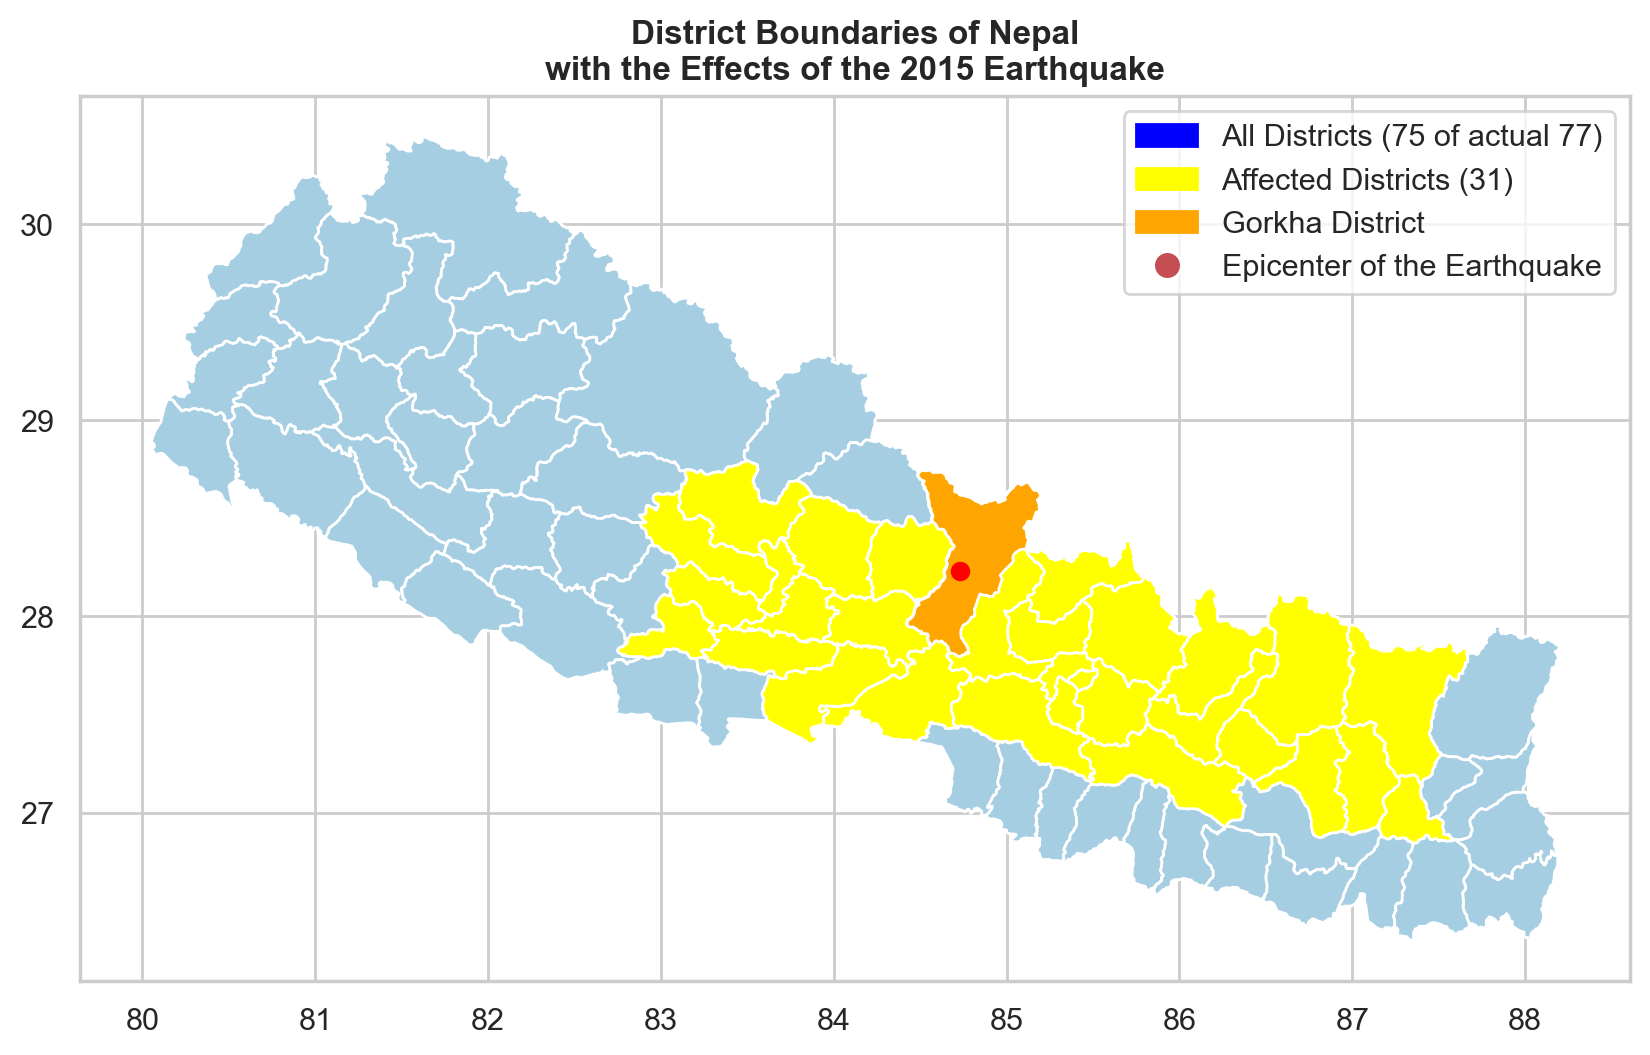

In [533]:
# Plot the district boundaries
fig, ax = plt.subplots(figsize = (10,10))

# Plot all districts
gdf_districts.plot(ax=ax, label=f'All Districts ({gdf_districts.shape[0]} of actual 77)')
# Plot only affected districts, where surcey has taken place
affected_districts = gdf_districts[gdf_districts['district'].isin(df_survey_stats['district'])]
affected_districts.plot(ax=ax, color='yellow', label=f'Affected Districts ({affected_districts.shape[0]})')
# Plot district with epicenter of the earthquake
district_gorkha = gdf_districts[gdf_districts['district'] == 'Gorkha']
district_gorkha.plot(ax=ax, color='orange', label='Gorkha')
# Plot the epicenter of the earthquake
plt.plot(84.731, 28.230, 'o', color='red' ,label='Epicenter of the Earthquake')

# Set title
ax.set_title('District Boundaries of Nepal' + '\n' + 'with the Effects of the 2015 Earthquake', fontweight='bold')
# Create custom legend handles
all_districts_handle = Patch(color='blue', label='All Districts (75 of actual 77)')
affected_districts_handle = Patch(color='yellow', label='Affected Districts (31)')
gorkha_district_handle = Patch(color='orange', label='Gorkha District')
epicenter_handle = Line2D([0], [0], marker='o', color='w', label='Epicenter of the Earthquake', markerfacecolor='r', markersize=10)
# Display the legend with custom handles
ax.legend(handles=[all_districts_handle,
                   affected_districts_handle,
                   gorkha_district_handle,
                   epicenter_handle], loc='upper right')
# Show the plot
plt.show()

Map looks similiar to the map plots in reports about the earthquake in Nepal, referring to the affected districts. So the district boundaries seem to be correct (For example [here](https://www.sciencedirect.com/topics/earth-and-planetary-sciences/gorkha-earthquake-2015)).

## Add latitude and longitude of the center of each district

In [534]:
geocoded_districts = gdf_districts.copy()
# Get current CRS information
crs = geocoded_districts.crs
print(crs)
# Determine the target projected CRS (UTM zone 45S)
target_crs = 'EPSG:32645'
# Reproject the geometries to the target CRS
geocoded_districts = geocoded_districts.to_crs(target_crs)
# Calculate the centroid of each district boundary and create a new GeoDataFrame
geocoded_districts['center'] = geocoded_districts['geometry'].centroid
# Extract latitude, longitude and altitude
geocoded_districts['latitude'] = geocoded_districts['center'].y
geocoded_districts['longitude'] = geocoded_districts['center'].x

EPSG:4326


In [535]:
geocoded_districts

,district,geometry,center,latitude,longitude
0,Humla,"POLYGON ((-38639.463 3371920.488, -38693.278 3...",POINT (6036.224 3333311.846),3.333312e+06,6036.223904
1,Darchula,"POLYGON ((-70153.987 3339619.263, -70374.008 3...",POINT (-100025.554 3323014.624),3.323015e+06,-100025.553954
2,Bajhang,"POLYGON ((-70153.987 3339619.263, -70122.973 3...",POINT (-63733.098 3300544.586),3.300545e+06,-63733.097783
3,Mugu,"POLYGON ((65425.145 3321868.911, 65587.022 332...",POINT (51456.375 3285297.119),3.285297e+06,51456.374658
4,Bajura,"POLYGON ((-30830.581 3319972.415, -30535.669 3...",POINT (-27038.970 3282469.462),3.282469e+06,-27038.969862
...,...,...,...,...,...
70,Sarlahi,"POLYGON ((382702.784 3004906.343, 382407.809 3...",POINT (357466.308 2985600.593),2.985601e+06,357466.307505
71,Mahottari,"POLYGON ((395288.898 2997176.402, 394867.986 2...",POINT (382750.703 2974051.109),2.974051e+06,382750.703182
72,Siraha,"POLYGON ((426564.057 2977492.529, 426574.799 2...",POINT (434391.420 2959702.314),2.959702e+06,434391.420005
73,Saptari,"POLYGON ((502432.428 2955211.974, 502390.792 2...",POINT (472635.883 2943982.406),2.943982e+06,472635.883357


In [536]:
# check for nan values in geometry column
geocoded_districts[geocoded_districts['geometry'].isnull()]

,district,geometry,center,latitude,longitude


## Add min and max distance to epicenter of the earthquake
To avoid duplicate code and to keep the notebook as well as the source code clean the functions implemented in another notebook, by another team member, are used (see notebook [week06-distance-to-epicenter.ipynb](week06-distance-to-epicenter.ipynb)). They were further improved by adding docstrings and explanations. This is done in this notebook to summarize all geographical data in one GeoDataFrame and one csv file. Also, we need one csv file to add the new geographical data to the training data in the actual source code.

In [543]:
def min_dist(row):
    """
    Calculates the minimum distance from the epicenter to the district boundary. The function is ment to be applied on dataframe rows. The epicenter is located at the following coordinates: 84.731, 28.230 (longitude, latitude) (see https://en.wikipedia.org/wiki/2015_Nepal_earthquake). The distance is calculated in kilometers. The function uses the WGS 84 coordinate reference system (EPSG:4326) for the latitude and longitude values and the WGS 84 / UTM zone 45N coordinate reference system (EPSG:32645) for the distance calculation.

    :param row: The current row of the GeoDataFrame.
    :type row: GeoSeries

    :return: The minimum distance from the epicenter to the district boundary in kilometers.
    :rtype: float
    """
    # Create a GeoSeries from the geometry of the current row
    series = gpd.GeoSeries(row.geometry)
    # Determine the current CRS of the GeoSeries
    series.crs = 'EPSG:32645'

    # Create a GeoSeries from the epicenter coordinates
    epicenter = gpd.GeoSeries([Point(84.731, 28.230)])
    # Determine the current CRS of the GeoSeries
    epicenter.crs = 'EPSG:4326'
    # Reproject the GeoSeries to the CRS of the GeoSeries of the current row
    epicenter = epicenter.to_crs('EPSG:32645')

    dist = series.distance(epicenter, align=False)

    return round(dist.iloc[0], 0) / 1000

In [544]:
def max_dist(row):
    """
    Calculates the maximum distance from the epicenter to the district boundary. The function is ment to be applied on dataframe rows. The epicenter is located at the following coordinates: 84.731, 28.230 (longitude, latitude) (see https://en.wikipedia.org/wiki/2015_Nepal_earthquake). The distance is calculated in kilometers. The function uses the WGS 84 coordinate reference system (EPSG:4326) for the latitude and longitude values and the WGS 84 / UTM zone 45N coordinate reference system (EPSG:32645) for the distance calculation.

    :param row: The current row of the GeoDataFrame.
    :type row: GeoSeries

    :return: The maximum distance from the epicenter to the district boundary in kilometers.
    :rtype: float
    """
    # Create a GeoSeries from the epicenter coordinates
    epicenter = gpd.GeoSeries([Point(84.731, 28.230)])
    # Determine the current CRS of the GeoSeries
    epicenter.crs = 'EPSG:4326'
    # Reproject the GeoSeries to the UTM zone 45N CRS
    epicenter = epicenter.to_crs('EPSG:32645')

    # Create a GeoSeries from the geometry of the current row
    s = gpd.GeoSeries(row.geometry)
    # Determine the current CRS of the GeoSeries
    s.crs = 'EPSG:32645'

    max_dist = 0
    # Traverse all points in the current districts shape file
    for b in s.boundary:
        coords = np.dstack(b.coords.xy).tolist()
        if len(coords) != 1:
            print(f"\nCheck manually on {row.district}\n")
        coords = coords[0]

        # Traverse all points in this district
        for p in coords:
            t = gpd.GeoSeries([Point(p[0], p[1])])
            t.crs = 32645

            temp_dist = t.distance(epicenter, align=False)
            temp_dist = temp_dist.iloc[0]

            if temp_dist > max_dist:
                max_dist = temp_dist

    return round(max_dist, 0) / 1000

In [545]:
# Filter ony relevant affected districts
geocoded_districts_affected = geocoded_districts.copy()
geocoded_districts_affected = geocoded_districts_affected[geocoded_districts_affected['district'].isin(df_survey_stats['district'])]

In [546]:
# Add max and min distance to epicenter in km
geocoded_districts_affected['min_dist_epicenter'] = geocoded_districts_affected.apply(min_dist, axis=1)
geocoded_districts_affected['max_dist_epicenter'] = geocoded_districts_affected.apply(max_dist, axis=1)

In [547]:
geocoded_districts_affected

,district,geometry,center,latitude,longitude,min_dist_epicenter,max_dist_epicenter
17,Dolakha,"POLYGON ((452323.669 3092562.954, 452376.834 3...",POINT (420650.533 3073502.534),3.073503e+06,420650.532581,131.265,183.968
21,Myagdi,"POLYGON ((157063.679 3189789.098, 157701.854 3...",POINT (153660.165 3163653.747),3.163654e+06,153660.165145,94.401,165.805
22,Gorkha,"POLYGON ((254942.588 3181439.471, 256273.931 3...",POINT (283350.509 3134539.910),3.134540e+06,283350.508985,0.000,63.833
25,Baglung,"POLYGON ((96653.999 3156853.546, 96733.104 315...",POINT (132734.662 3141237.508),3.141238e+06,132734.661700,103.755,184.598
26,Kaski,"POLYGON ((233446.132 3152426.276, 233145.396 3...",POINT (205768.079 3140158.463),3.140158e+06,205768.078910,50.364,102.870
27,Lamjung,"POLYGON ((261751.808 3153635.225, 262244.847 3...",POINT (247952.310 3132232.291),3.132232e+06,247952.309518,8.395,53.637
28,Parbat,"POLYGON ((166861.937 3134958.946, 166936.847 3...",POINT (174137.850 3124875.007),3.124875e+06,174137.850214,89.091,116.640
29,Rasuwa,"POLYGON ((315665.888 3135808.507, 315920.444 3...",POINT (343989.089 3118500.065),3.118500e+06,343989.088655,39.509,104.284
30,Tanahu,"POLYGON ((205526.172 3113702.023, 205739.395 3...",POINT (229734.365 3095317.869),3.095318e+06,229734.365460,30.827,86.990
31,Solukhumbu,"POLYGON ((452323.669 3092562.954, 452256.953 3...",POINT (472118.146 3065377.263),3.065377e+06,472118.146260,176.899,234.762


# Map geo_level_1_id to district (district -> geo_level_1_id)

In [548]:
# calculate geo level stats of train data
X_train_count = X_train["geo_level_1_id"].value_counts().reset_index().rename({"index": "geo_level_1_id", "geo_level_1_id": "count_absolute"}, axis=1)
X_train_count["count_total"] = X_train_count["count_absolute"].sum()
X_train_count["count_relative"] = X_train_count["count_absolute"] / X_train_count["count_total"] * 100

In [549]:
# sort appearance of geo_level_1_id in train data by it`s absolute count for comparison and geo_level_1_id mapping
X_train_count.sort_values(by="count_absolute", inplace=True, ascending=False, ignore_index=True)

In [550]:
X_train_count

,geo_level_1_id,count_absolute,count_total,count_relative
0,6,24381,260601,9.355682
1,26,22615,260601,8.678017
2,10,22079,260601,8.472339
3,17,21813,260601,8.370267
4,8,19080,260601,7.321538
5,7,18994,260601,7.288537
6,20,17216,260601,6.606268
7,21,14889,260601,5.713332
8,4,14568,260601,5.590155
9,27,12532,260601,4.808884


In [551]:
# sort appearance of districts in survey data by it`s absolute count for comparison and geo_level_1_id mapping
df_survey_stats.sort_values(by="cases_absolute", inplace=True, ascending=False, ignore_index=True)

In [552]:
df_survey_stats

,dcode,district,cases_absolute,cases_total,cases_relative
0,24,Kavrepalanchok,90497,996588,9.080683
1,30,Dhading,85255,996588,8.554689
2,31,Makwanpur,85188,996588,8.547966
3,23,Sindhupalchok,83589,996588,8.387518
4,36,Gorkha,74389,996588,7.464368
5,28,Nuwakot,72871,996588,7.312049
6,20,Sindhuli,62900,996588,6.311535
7,22,Dolakha,57691,996588,5.788852
8,21,Ramechhap,54345,996588,5.453106
9,27,Kathmandu,48133,996588,4.829779


### Plot district vs. geo_level_1_id distribution

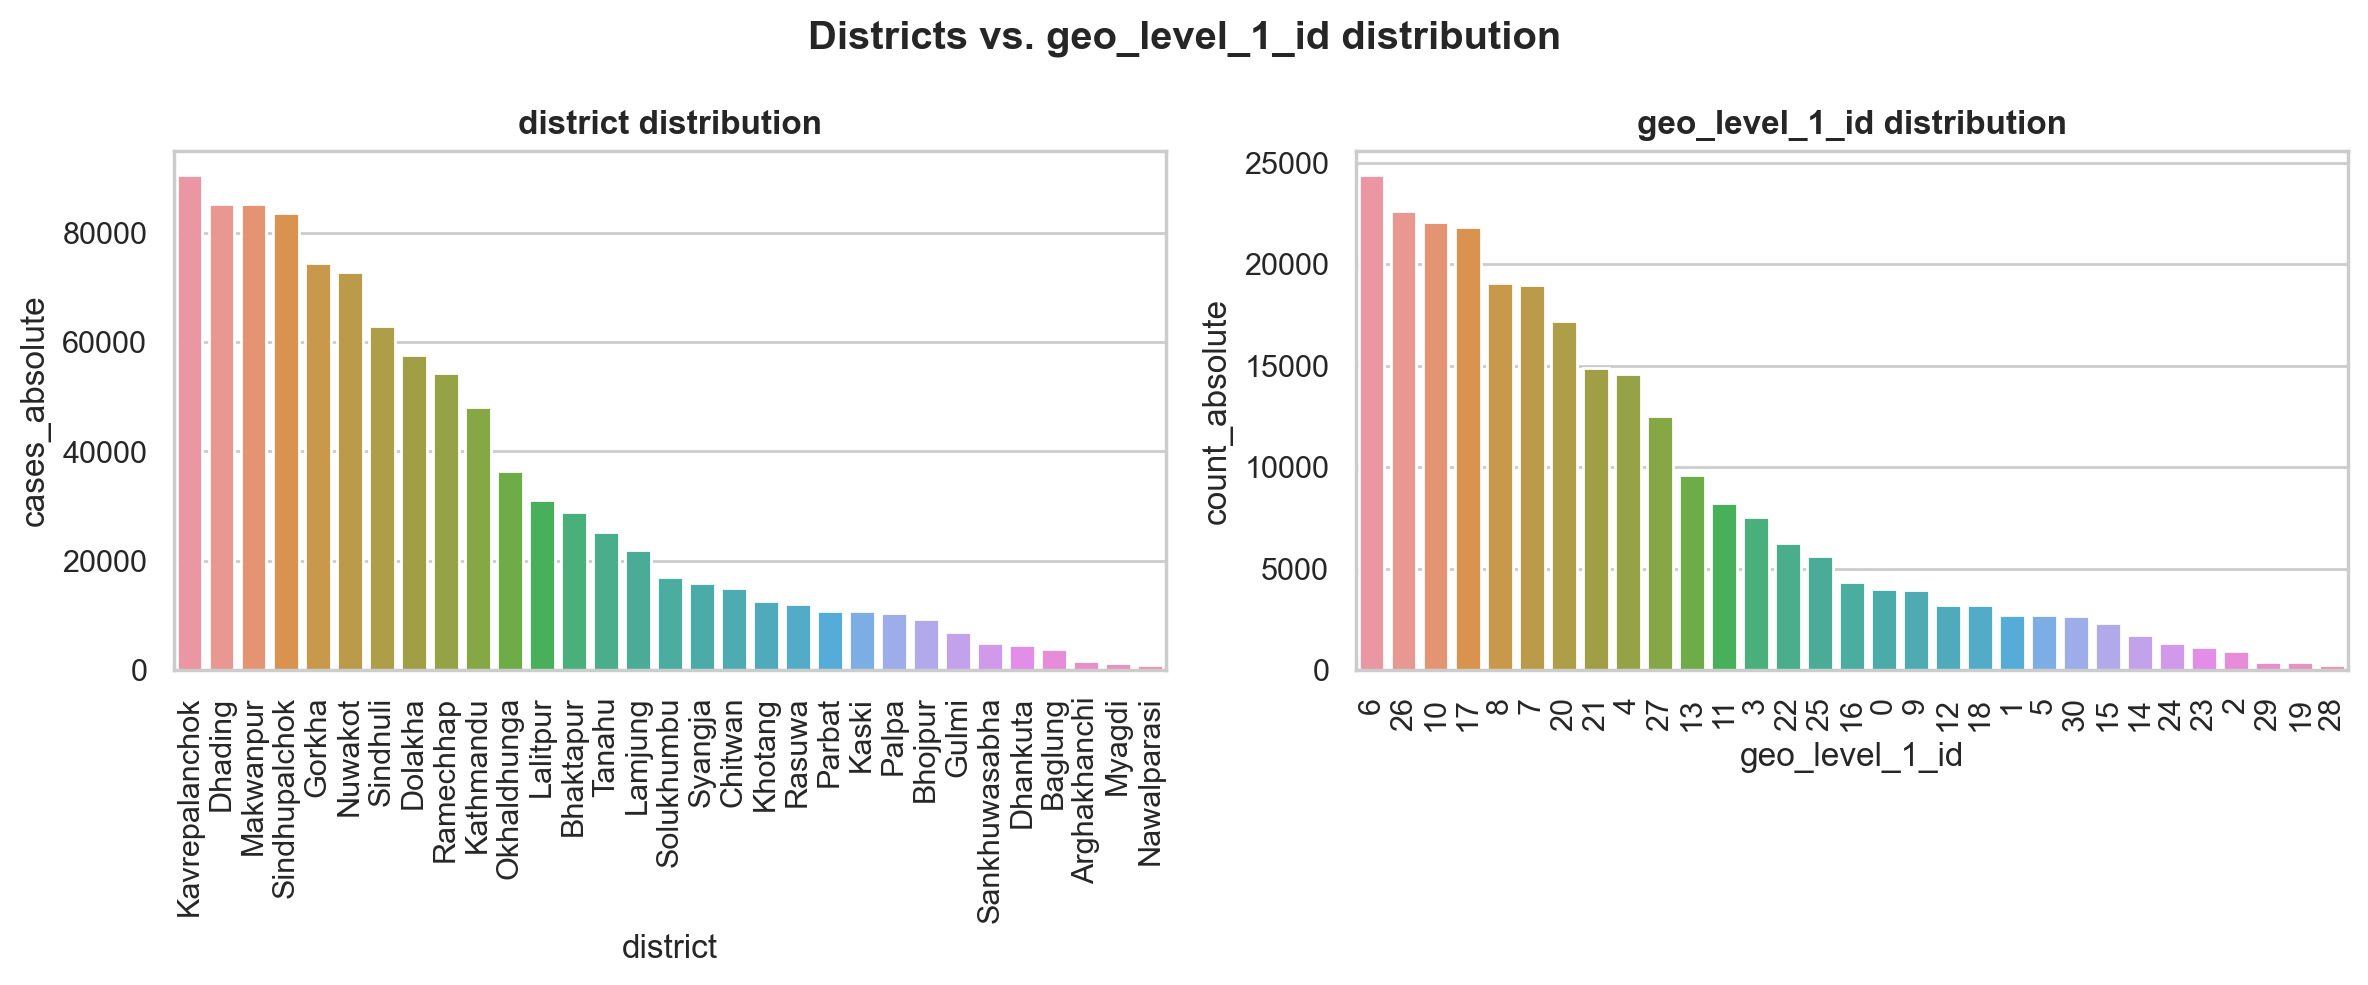

In [553]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot district cases distribution
sns.barplot(data=df_survey_stats, x="district", y="cases_absolute", ax=ax[0])
# Set title
ax[0].set_title("district distribution", fontweight="bold")
# Rotate xticks
ax[0].tick_params(axis='x', rotation=90)

# Plot data districts distribution
# Change geo_level_1_id from int to string --> otherwise seaborn plots it as a float
X_train_count["geo_level_1_id"] = X_train_count["geo_level_1_id"].astype(str)
# Plot
sns.barplot(data=X_train_count, x="geo_level_1_id", y="count_absolute", ax=ax[1])
# Set title
ax[1].set_title("geo_level_1_id distribution", fontweight="bold")
# Rotate xticks
ax[1].tick_params(axis='x', rotation=90)

# Set title
fig.suptitle("Districts vs. geo_level_1_id distribution", fontweight="bold")

plt.tight_layout()
plt.show()

**Findings:** The distribution of districts and geo_level_1_id is very similar but not exactly the same as we can see above in the plot and also in the realitve distribution numbers. However, it is at least worth a try to map the geocoded information, being langitude, longitude and district name to the actual train dataset as new features using the geo_level_1_id as a key. This key is already present in the train dataset and can be mapped to the actual district name by comparing the distribution of the train dataset and the geocoded districts.

Note: This assumption was made because the survey was conducted in exactly 31 districts of Nepal and the train dataset contains exactly 31 geo_level_1_id's. More over additional survey data is made publicly available by the actual nepalese government containing information about the actual number of cases, the survey response rate, in each district. Using this information we can compare the distributions, which should be the same in relative numbers, and map the actual district names to the train dataset. Having that information we can use it to add geocoded information about the district directly without using just a simple categoric id.

In [554]:
# Save mapping of district name, dcode to geo_level_1_id
district_mapping = pd.concat([df_survey_stats["district"], X_train_count["geo_level_1_id"]], axis=1)

In [555]:
# Convert to dict for mapping of geo_level_1_id to district name
district_mapping_dict = district_mapping.set_index("district").to_dict()["geo_level_1_id"]

In [556]:
district_mapping_dict

{'Kavrepalanchok': '6',
 'Dhading': '26',
 'Makwanpur': '10',
 'Sindhupalchok': '17',
 'Gorkha': '8',
 'Nuwakot': '7',
 'Sindhuli': '20',
 'Dolakha': '21',
 'Ramechhap': '4',
 'Kathmandu': '27',
 'Okhaldhunga': '13',
 'Lalitpur': '11',
 'Bhaktapur': '3',
 'Tanahu': '22',
 'Lamjung': '25',
 'Solukhumbu': '16',
 'Syangja': '0',
 'Chitwan': '9',
 'Khotang': '12',
 'Rasuwa': '18',
 'Parbat': '1',
 'Kaski': '5',
 'Palpa': '30',
 'Bhojpur': '15',
 'Gulmi': '14',
 'Sankhuwasabha': '24',
 'Dhankuta': '23',
 'Baglung': '2',
 'Arghakhanchi': '29',
 'Myagdi': '19',
 'Nawalparasi': '28'}

### Conclusion: Add geo_level_1_id to survey stats and affected, geocoded districts

In [557]:
# Add geo_level_1_id to survey_stats as a key to merge with X_train
df_survey_stats["geo_level_1_id"] = df_survey_stats["district"].map(district_mapping_dict)
# Add geo_level_1_id to affected_geocoded_district as a key to merge with X_train
geocoded_districts_affected["geo_level_1_id"] = geocoded_districts_affected["district"].map(district_mapping_dict)

In [558]:
# Move geo_level_1_id to the front of the DataFrame
df_survey_stats = df_survey_stats.reindex(['geo_level_1_id', 'district', 'cases_absolute', 'cases_total', 'cases_relative'], axis=1)
geocoded_districts_affected = geocoded_districts_affected.reindex(['geo_level_1_id', 'district', 'latitude', 'longitude', 'min_dist_epicenter', 'max_dist_epicenter'], axis=1)

In [559]:
geocoded_districts_affected

,geo_level_1_id,district,latitude,longitude,min_dist_epicenter,max_dist_epicenter
17,21,Dolakha,3.073503e+06,420650.532581,131.265,183.968
21,19,Myagdi,3.163654e+06,153660.165145,94.401,165.805
22,8,Gorkha,3.134540e+06,283350.508985,0.000,63.833
25,2,Baglung,3.141238e+06,132734.661700,103.755,184.598
26,5,Kaski,3.140158e+06,205768.078910,50.364,102.870
27,25,Lamjung,3.132232e+06,247952.309518,8.395,53.637
28,1,Parbat,3.124875e+06,174137.850214,89.091,116.640
29,18,Rasuwa,3.118500e+06,343989.088655,39.509,104.284
30,22,Tanahu,3.095318e+06,229734.365460,30.827,86.990
31,16,Solukhumbu,3.065377e+06,472118.146260,176.899,234.762


In [560]:
df_survey_stats

,geo_level_1_id,district,cases_absolute,cases_total,cases_relative
0,6,Kavrepalanchok,90497,996588,9.080683
1,26,Dhading,85255,996588,8.554689
2,10,Makwanpur,85188,996588,8.547966
3,17,Sindhupalchok,83589,996588,8.387518
4,8,Gorkha,74389,996588,7.464368
5,7,Nuwakot,72871,996588,7.312049
6,20,Sindhuli,62900,996588,6.311535
7,21,Dolakha,57691,996588,5.788852
8,4,Ramechhap,54345,996588,5.453106
9,27,Kathmandu,48133,996588,4.829779


In [561]:
# Updated survey stats
df_survey_stats.to_csv("../../data/processed/survey_stats.csv", index=False)
# Updated affected geocoded districts
geocoded_districts_affected.to_csv("../../data/processed/geocoded_districts_affected.csv", index=False)

# Build function adding geocoded information to X_train

In [562]:
def get_geocoded_info(df, geo_path, drop_key=False):
    """
    Get and add geocoded information to X_train. The geocoded information is the district name, latitude and longitude. The district name is mapped to the geo_level_1_id of X_train. The latitude and longitude are mapped to the district name. The geocoded information is added as new features to X_train.

    :param df: X_train without geocoded information.
    :type df: pandas.DataFrame
    :param geo_path: Path to geocoded districts.
    :type geo_path: str
    :param drop_key: Drop key, geo_level_1_id, after merging, defaults to False.
    :type drop_key: bool, optional

    :return: X_train with geocoded information
    :rtype: pandas.DataFrame
    """
    # Load geocoded districts
    geo_df = pd.read_csv(geo_path)
    # Make sure key column is of the same type
    df["geo_level_1_id"] = df["geo_level_1_id"].astype(str)
    geo_df["geo_level_1_id"] = geo_df["geo_level_1_id"].astype(str)
    # Only select relevant columns
    geo_df = geo_df[["geo_level_1_id", 'district', 'latitude','longitude', 'min_dist_epicenter', 'max_dist_epicenter']]
    # Merge X_train with geocoded_districts
    df = pd.merge(df, geo_df, on="geo_level_1_id")
    if drop_key:
        # Drop geo_level_1_id
        df.drop("geo_level_1_id", axis=1, inplace=True)

    return df

In [563]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 39 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   building_id                             260601 non-null  int64 
 1   geo_level_1_id                          260601 non-null  int64 
 2   geo_level_2_id                          260601 non-null  int64 
 3   geo_level_3_id                          260601 non-null  int64 
 4   count_floors_pre_eq                     260601 non-null  int64 
 5   age                                     260601 non-null  int64 
 6   area_percentage                         260601 non-null  int64 
 7   height_percentage                       260601 non-null  int64 
 8   land_surface_condition                  260601 non-null  object
 9   foundation_type                         260601 non-null  object
 10  roof_type                               260601 non-null 

In [564]:
# Add geocoded information to X_train
geo_path = "../../data/processed/geocoded_districts_affected.csv"
geocoded_X_train = get_geocoded_info(X_train, geo_path, drop_key=False)

In [565]:
geocoded_X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 0 to 260600
Data columns (total 44 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   building_id                             260601 non-null  int64  
 1   geo_level_1_id                          260601 non-null  object 
 2   geo_level_2_id                          260601 non-null  int64  
 3   geo_level_3_id                          260601 non-null  int64  
 4   count_floors_pre_eq                     260601 non-null  int64  
 5   age                                     260601 non-null  int64  
 6   area_percentage                         260601 non-null  int64  
 7   height_percentage                       260601 non-null  int64  
 8   land_surface_condition                  260601 non-null  object 
 9   foundation_type                         260601 non-null  object 
 10  roof_type                               2606